# drosophila_simulation_cauterized

> copy of notebook `04_drosophila_simulation` to simulate ``cauterized'' embryos where extension is blocked

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize, ndimage

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

In [ ]:
## reloading the modules in case you edit them

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

In [ ]:
# might need to modify the initial condition routine in various simulations. Here, it turns out to
# be helpful to lower the strength of the boundary penalties at the left/right sides

def create_rect_initial(nx, ny, noise=0, initial_strain=0, isogonal=0, orientation='orthogonal',
                        boundaries=None, w_passive=0, w_passive_lr=0,
                        bdry_x=None, bdry_y=None, bdr_AP_reduction=1/500,
                        random_seed=0):
    """
    Create initial condition for germ band simulations.
    
    Creates a HalfEdgeMesh from a rectangulat patch of triangular lattice, creates boundary conditions,
    selects active and passive triangles, creates a dictionary with the initial rows of active cells,
    and sets edge rest lengths and cell rest shapes.
    
    Random seed for noise can be specified for reproducible results.
    
    Parameters
    ----------
    nx, ny: int
        Width and height of rectangular patch
    noise: float
        Standard deviation of the noise added to the initial vertex positions
    initial_strain: float
        Initial y-axis strain applied to tension triangulation. Applies transform matrix
        diag(1/(1+s), 1+s)
    orientation: 'orthogonal' or 'parallel'
        Orientation of hexagonal lattice direction w.r.t. y-axis.
    boundaries: list of 'top', 'bottom', 'left', 'right'
        On which sides to add slip walls.
    w_passive: float
        Width of passive region on the top and bottom
    bdry_x, bdry_y: float
        Location of the the left/right and top/bottom slip walls. If None, set to initial mesh positions
    random_seed: int
        Numpy random number generator seed.
        
    """
    np.random.seed(random_seed)
    # create the mesh
    if orientation == 'parallel':
        nx, ny = (ny, nx)
    mesh_initial = iso.CellHalfEdgeMesh(dln.create_rect_mesh(ny, nx, noise=noise, defects=(0, 0),
                                                             straight_bdry=False))
    if orientation == 'orthogonal':
        mesh_initial.transform_vertices(dln.rot_mat(np.pi/2))
    center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
    mesh_initial.transform_vertices(lambda x: x-center)
    mesh_initial.set_voronoi()
    
    mesh_initial.transform_vertices(dln.shear_mat(1+initial_strain))
    mesh_initial.set_rest_lengths()
    
    # create the boundary conditions
    boundaries = [] if boundaries is None else boundaries
    bdry_list = []
    max_x_cells = np.max([v.get_centroid()[0] for v in mesh_initial.vertices.values() if not v.is_bdry()])
    max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

    bdry_x = np.ceil(max_x_cells) if bdry_x is None else bdry_x
    bdry_y = np.ceil(max_y_cells) if bdry_y is None else bdry_y
    
    w_bdry = .4
    
    if 'top' in boundaries:
        top_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
                top_ids.append(v._vid)
        def top_penalty(x):
            return (x[1]-bdry_y)**2
        top_penalty = Partial(jit(top_penalty))
        bdry_list.append([top_penalty, top_ids])

    if 'bottom' in boundaries:
        bottom_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
                bottom_ids.append(v._vid)
        def bottom_penalty(x):
            return (x[1]+bdry_y)**2
        bottom_penalty = Partial(jit(bottom_penalty))
        bdry_list.append([bottom_penalty, bottom_ids])
        
    if 'left' in boundaries:
        left_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[0] < -(max_x_cells-w_bdry)) and (not v.is_bdry()):
                left_ids.append(v._vid)
        def left_penalty(x):
            return bdr_AP_reduction*(x[0]+bdry_x)**2
        left_penalty = Partial(jit(left_penalty))
        bdry_list.append([left_penalty, left_ids])

    if 'right' in boundaries:
        right_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[0] > (max_x_cells-w_bdry)) and (not v.is_bdry()):
                right_ids.append(v._vid)
        def right_penalty(x):
            return bdr_AP_reduction*(x[0]-bdry_x)**2
        right_penalty = Partial(jit(right_penalty))
        bdry_list.append([right_penalty, right_ids])    
    mesh_initial.bdry_list = bdry_list
        
    # set the active and passive triangles
    passive_faces = []
    max_y_faces = np.max([val.primal_coords[1] for val in mesh_initial.faces.values()])
    max_x_faces = np.max([val.primal_coords[0] for val in mesh_initial.faces.values()])

    for fc in mesh_initial.faces.values():
        if (fc.is_bdry()
            or (np.abs(fc.primal_coords[1]) > (max_y_faces-w_passive))
            or (np.abs(fc.primal_coords[0]) > (max_x_faces-w_passive_lr))):
            passive_faces.append(fc._fid)
            
    passive_faces = sorted(passive_faces)
    passive_edges = list(msh.flatten([[he._heid for he in mesh_initial.faces[fc].hes] for fc in passive_faces]))
    passive_cells = [v._vid for v in mesh_initial.vertices.values()
                     if not v.is_bdry() and any([fc._fid in passive_faces for fc in v.faces])]

    # create dict of initial row ids
    if orientation == 'parallel':
        initial_row_dict = {key: np.round((2/np.sqrt(3))*val.get_centroid()[1]+.5, decimals=0)
                            for key, val in mesh_initial.vertices.items()
                            if (not key in passive_cells) and (not val.is_bdry())}
    elif orientation == 'orthogonal':
        initial_row_dict = {key: np.round(val.get_centroid()[1], decimals=0)
                            for key, val in mesh_initial.vertices.items()
                            if (not key in passive_cells) and (not val.is_bdry())}
    min_val = min(initial_row_dict.values())
    initial_row_dict = {key: int(val-min_val) for key, val in initial_row_dict.items()}
    
    # set isogonal mode for active cells.
    for v in mesh_initial.vertices.values():
        if v._vid in passive_cells:
            v.rest_shape = np.sqrt(3) * np.array([[1, 0],[0, 1]])
        else:
            v.rest_shape = np.sqrt(3) * np.array([[1-isogonal, 0],[0, 1+isogonal]])

    property_dict = {'initial_row_dict': initial_row_dict, 'passive_faces': passive_faces,
                     'passive_edges': passive_edges, 'passive_cells': passive_cells,
                     'bdry_x': bdry_x, 'bdry_y': bdry_y}
    
    return mesh_initial, property_dict

## Simulation with boundary conditions and passive & active cells

For starters, simply divide the cells into active $m=4$ and passive, $m=1$. Might be better to make this more gradual. 

### Plot initial condition

In [ ]:
#| notest
%matplotlib inline

In [ ]:
importlib.reload(msh)
importlib.reload(tns)
importlib.reload(dln)
importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

In [ ]:
## create and plot the initial condition
## create and plot the initial condition

mesh_initial, property_dict = create_rect_initial(22, 26, noise=0.1, initial_strain=0.1,
                                                  orientation='orthogonal', isogonal=0,
                                                  boundaries=['top', 'bottom'], #'left', 'right'],
                                                  bdr_AP_reduction=1/500, bdry_x=9.45,
                                                  w_passive=4, w_passive_lr=2.5, random_seed=3)

In [ ]:
property_dict["bdry_x"]

9.45

In [ ]:
# set colors for edges and cells
edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_alpha = .5
cell_colors = {key: np.hstack([fridtjof_colors[val % fridtjof_colors.shape[0]], [cell_alpha]])
               for key, val in property_dict['initial_row_dict'].items()}

cell_colors_active = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
                      for key in mesh_initial.vertices.keys()
                      if not key in property_dict['passive_cells']}

(-9.95, 9.95, -12.5, 12.5)

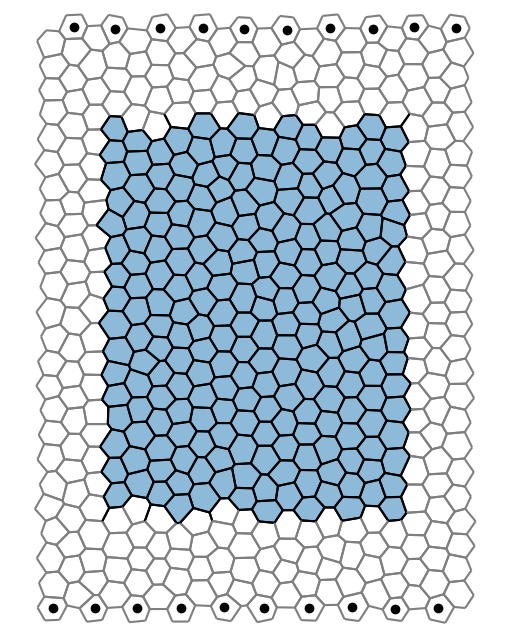

In [ ]:
fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors,
                      cell_colors=cell_colors_active)

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
if mesh_initial.bdry_list:
    for key in msh.flatten([x[1] for x in mesh_initial.bdry_list]):
        plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-.5, bdry_y+.5])

plt.axis("off")

#plt.savefig("plots/SI figs and movies/initial_cond_cauterized.pdf")

## set simulation parameters

In [ ]:
# might need much larger k for passive

In [ ]:
## feedback parameters

m = 4
k = .5  # . 5
k_cutoff = .25 # regularization term
 
passive_ids = property_dict['passive_faces']
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": .15, "m": 1} # lower k here makes the passive region less lattice-like
    # might add an extra case for the edges in slip-wall boundary cells
    return {"k": k, "m": m, "k_cutoff": k_cutoff}

params_no_pattern = {"k": k, "m": m, "k_cutoff": k_cutoff}
    
dt = .005 # time step
n_steps = 91
forbid_reflip = 20
minimal_l = .05 # .075 inimal edge length, lower edge lengths trigger T1

tri_mod_area = .02 # .01 triangle area regularization

In [ ]:
## cell shape parameters

tol, maxiter = (1e-4, 100000)  #1e-4
mod_bulk = 1
mod_shear = .25 # .5
angle_penalty = 1000
bdry_penalty = 5000

epsilon_l = (1e-3, 1e-4)  # interesting. going below 1e-3 leads the optimizer to fail, typically.

A0 = jnp.sqrt(3)/2
mod_area = 0
P0 = 2*jnp.sqrt(3)/2
mod_perimeter = 0

bdr_weight = 4 # 2

passive_cells = property_dict['passive_cells']
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

use_voronoi = False # don't do shape optimization, run voronoi instead

In [ ]:
# package all into a single dict to pass to the optimizer method

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l,
               "A0": A0, "mod_area": mod_area, "P0": P0, "mod_perimeter": mod_perimeter}
optimizer_args = {'energy_args': energy_args, 'cell_id_to_modulus': cell_id_to_modulus,
                  'tol': tol, 'maxiter': maxiter, 'verbose': True, 'bdr_weight': bdr_weight}

In [ ]:
## rest length relaxation

k_rest = 0

def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    if (v._vid in property_dict['passive_cells'])  and (not v.is_bdry()):
        delta = v.rest_shape-v.get_shape_tensor()
        return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    else:
        return 0
    #delta = v.rest_shape-v.get_vrtx_shape_tensor()
    #return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))


## Simulation loop

Note: when saving, we need to save some additional data (the passive tensions and the cell rest shapes) which are not by default saved by the `HalfEdgeMesh` save routine. They are saved as dicts, so that after loading the properties can be set again, for example to continue simulating.

In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

In [ ]:
save = True
save_dir = "plots/SI figs and movies/cauterized_soft_bdr_control/"
try:
    os.mkdir(save_dir)
except FileExistsError:
    print('Warning: directory exists')
drs.save_self(save_dir, fname='04c_drosophila_simulation_cauterized.ipynb'):

In [ ]:
## simulation loop

mesh = deepcopy(meshes[-1])
for i in tqdm(range(len(meshes)-1, n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass, params=params_pattern,
                    rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4)
    # primal optimization
    if use_voronoi:
        mesh.set_voronoi()
    else:
        mesh.optimize_cell_shape(**optimizer_args)
    # check for intercalation
    flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                            minimal_l=minimal_l, reoptimize=False, optimizer_args=optimizer_args)
    if failed_flip:
        print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
    if flipped and not failed_flip:
        print(f"tpt {i}: flip {flipped}")
    # rescale & reorient triangulation
    mesh.transform_vertices(dln.get_conformal_transform(meshes[-1], mesh))
    # log & save
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)
    if save:
        mesh.save_mesh(f"{save_dir}/{str(i).zfill(4)}_mesh", save_attribs=True)
last_flipped_edges.append([])


  0%|          | 0/91 [00:00<?, ?it/s]

tpt 5: flip [447]
tpt 11: flip [1227]
tpt 13: flip [1027]
tpt 14: flip [2433, 2755]
tpt 15: flip [687]
tpt 19: flip [711]
tpt 21: flip [1863, 445, 1881, 1144]
tpt 23: flip [2527, 2943]
tpt 24: flip [879, 2983, 1312]
tpt 25: flip [915, 2844]
tpt 26: flip [1855, 1837]
tpt 28: flip [2853, 1906]
tpt 29: flip [1365, 3121]
tpt 30: flip [2863, 1398]
tpt 31: flip [1645, 2965, 289]
tpt 32: flip [1695, 1662, 334]
tpt 33: flip [2568, 630]
tpt 34: flip [1221, 1867, 564, 1894, 2442]
tpt 35: flip [1939, 1669]
tpt 36: flip [256, 2557, 2415]
tpt 37: flip [561]
tpt 38: flip [1797, 1413]
tpt 39: flip [547, 2523, 2749, 2133, 2017, 2508]
tpt 40: flip [1687]
tpt 41: flip [2938, 3085]
tpt 42: flip [2941, 2506, 2566]
tpt 43: flip [2575]
tpt 44: flip [736, 2586, 2911]
tpt 45: flip [1312, 312, 430]
tpt 46: flip [1807, 2112, 543, 3070, 2649]
tpt 47: flip [1872]
tpt 49: flip [2539, 2286, 258, 1617, 2002, 1611, 1194]
tpt 50: flip [1408, 99, 264, 1981, 2259, 1225]
tpt 51: flip [273, 2593, 2902, 2449, 1606, 1863]
t

In [ ]:
last_flipped_edges.append([])

with open(save_dir+'last_flipped_edges.pickle', 'wb') as handle:
    pickle.dump(last_flipped_edges, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
meshes[-1].is_consistent()

In [ ]:
# measure extension

centroids = np.stack([[v.get_centroid() for key, v in mesh.vertices.items()
                       if key not in property_dict["passive_cells"] and not v.is_bdry()]
                       for mesh in meshes])

delta = np.quantile(centroids, axis=1, q=.9)-np.quantile(centroids, axis=1, q=.1,)
sigma = 2
delta_smooth = ndimage.gaussian_filter1d(delta, axis=0, sigma=sigma)[sigma:-sigma]
delta_smooth /= delta_smooth[0]


In [ ]:
delta_smooth[-1][0] / delta_smooth[-1][1]

1.308225756495578

### Loading a saved simulation

#### Slider plots

Most importantly, visualize the mesh

<IPython.core.display.Javascript object>


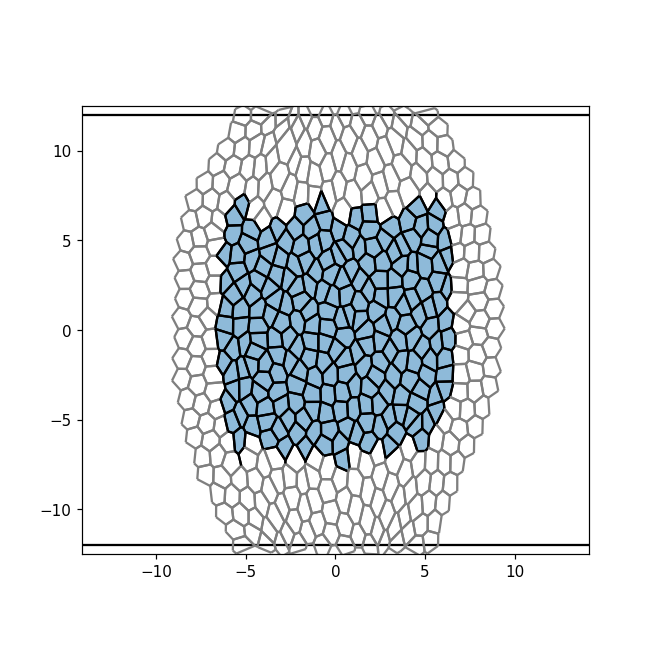

interactive(children=(IntSlider(value=45, description='i', max=91), FloatSlider(value=14.174999999999999, desc…

In [ ]:
#| notest

%matplotlib notebook

fig = plt.figure(figsize=(6, 6))
    
# fix the arguments which you do not need to tune with widgets.fixed

widgets.interact(drs.plot_mesh, i=(0, len(meshes)-1, 1), xlim=(bdry_x, 2*bdry_x),
                 ylim=widgets.fixed(bdry_y+.5), slipwall_y=widgets.fixed(bdry_y),
                 edge_colors=widgets.fixed(edge_colors), cell_colors=widgets.fixed(cell_colors_active),
                 mesh_series=widgets.fixed(meshes),
                 #flipped_series=widgets.fixed(None),
                 flipped_series=widgets.fixed(last_flipped_edges)
                );


In [ ]:
%matplotlib inline

### Analyze

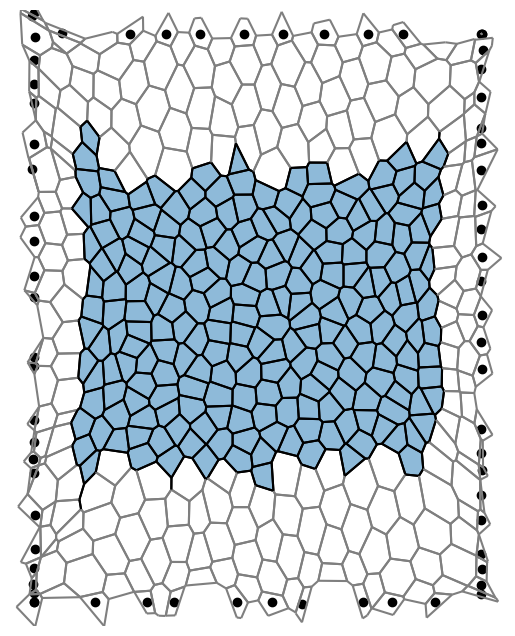

In [ ]:
## plot final configuration

fig = plt.figure(figsize=(8,8))

t = 90

meshes[t].cellplot(edge_colors=edge_colors,
                      cell_colors=cell_colors_active)

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
if mesh_initial.bdry_list:
    for key in msh.flatten([x[1] for x in mesh_initial.bdry_list]):
        plt.scatter(*meshes[t].vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-bdry_x-1, bdry_x+1])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")

plt.savefig("plots/SI figs and movies/final_cauterized_v2.pdf")

### New junction extension

In [ ]:
length_dicts = [x.get_primal_edge_lens() for x in meshes]

In [ ]:
t_ref = 35
dt = 35

lengths_stacked = []
for i in range(t_ref, t_ref+dt):
    for e in last_flipped_edges[i]:
        if not e in property_dict['passive_edges']:
            length = np.stack([x[e] for x in length_dicts])
            lengths_stacked.append(length[i-t_ref:i+t_ref])
            
lengths_stacked = np.stack(lengths_stacked)
np.save("lengths_stacked_cauterized_v2.npy", lengths_stacked)
# save, if necessary

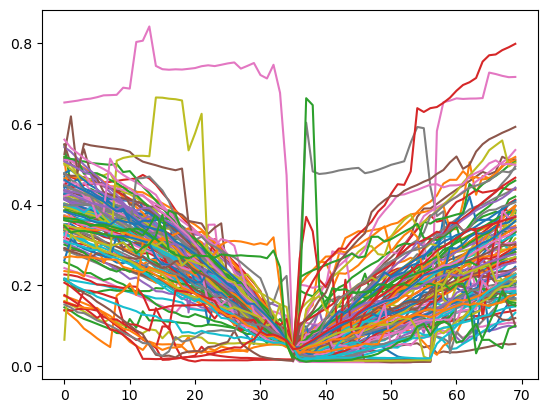

In [ ]:
for x in lengths_stacked:
    plt.plot(x)

In [ ]:
lengths_stacked_control = np.load('lengths_stacked_control.npy')

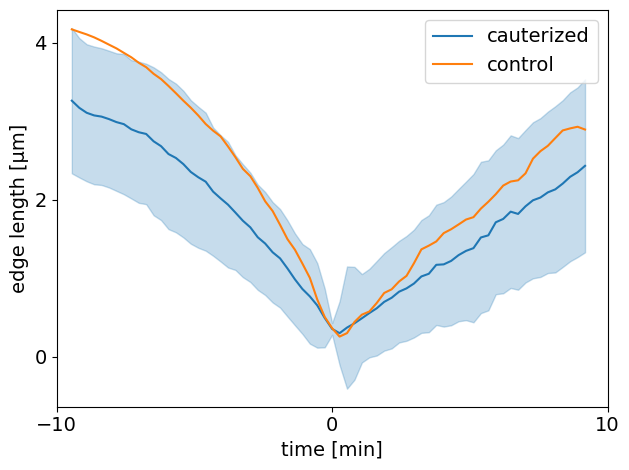

In [ ]:
time = .27*(np.arange(lengths_stacked.shape[1]) - 35.)  #.28

length_scale = 8.5  # 8.5

mean = np.median(lengths_stacked, axis=0) * length_scale
std = lengths_stacked.std(axis=0) * length_scale

mean_control = np.median(lengths_stacked_control, axis=0) * length_scale

plt.plot(time, mean, color='tab:blue', label='cauterized')
plt.fill_between(time, mean-std, mean+std, color='tab:blue', alpha=.25)

plt.plot(time, mean_control, color='tab:orange', label='control')


plt.xlim([-10, 10])
plt.xticks([-10, 0, 10], fontsize=14)
plt.yticks([0, 2, 4], fontsize=14)


plt.xlabel('time [min]', fontsize=14)
plt.ylabel('edge length [μm]', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig('plots/SI figs and movies/cauterized_junction_length.pdf')